In [1]:
# standard imports
from datetime import date
import random 
from imp import reload
#import warnings
#warnings.simplefilter("ignore")

# data analytics imports
import pandas as pd
import numpy as np

# graphics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

# time series analysis imports
import hts
from hts.hierarchy import HierarchyTree
from statsmodels.graphics.tsaplots import plot_acf

# FB Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly


# my own code
import forecasting.store_item_demand as sid
import forecasting.bplot as bplot

# Load data and preprocess it

In [2]:
df_test       = pd.read_csv('../data/test.csv')
df_train      = pd.read_csv('../data/train.csv')
df_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
df, df_h, hierarchy = sid.preprocess_data('../data/train.csv')


# no null entries
# 10 stores
# 50 items
# 50*10=500 separate time series, one for each store/item combination
# 1826 days = 5 years
# 1826*500 = 913'000 rows of sales data
    
Number of time series at the bottom level: 500
Number of time series at the middle level: 10
Number of time series at the top level   : 1


In [4]:
#tree = HierarchyTree.from_nodes(hierarchy, df_h, root='total')

# First look at the data

## Share of total sales by store

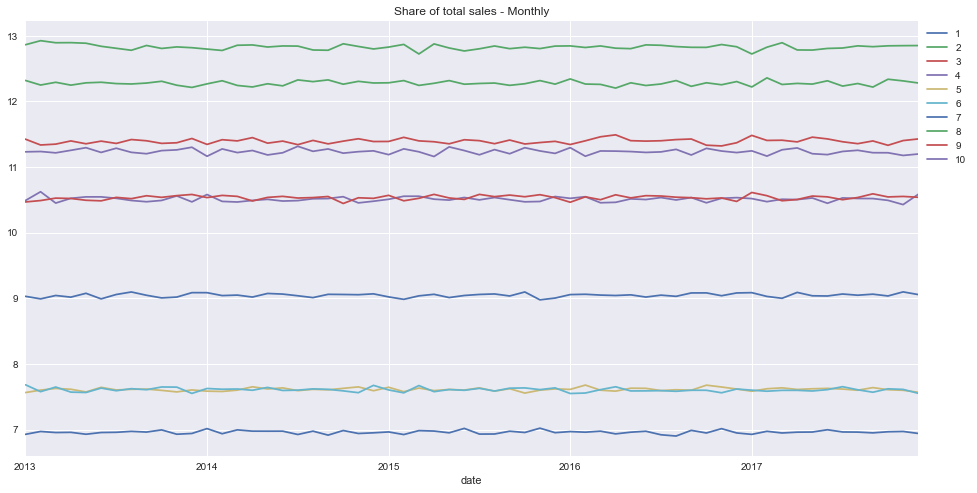

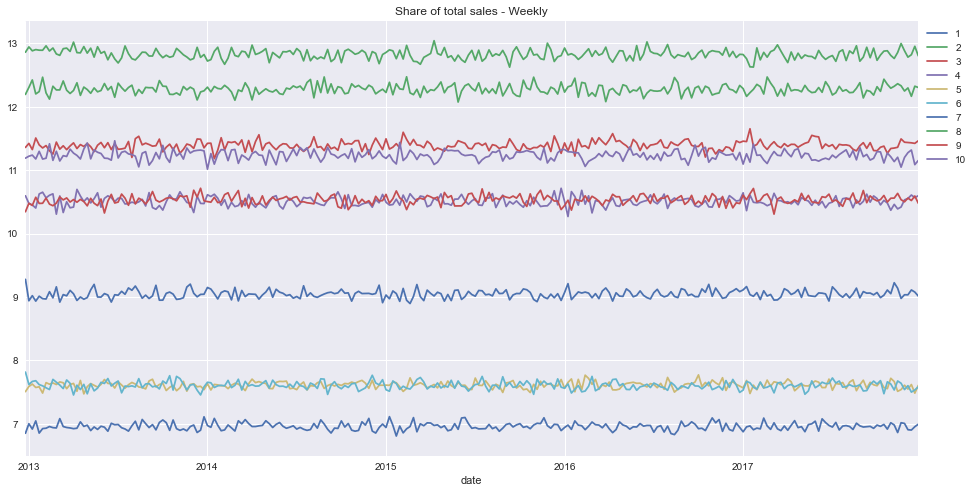

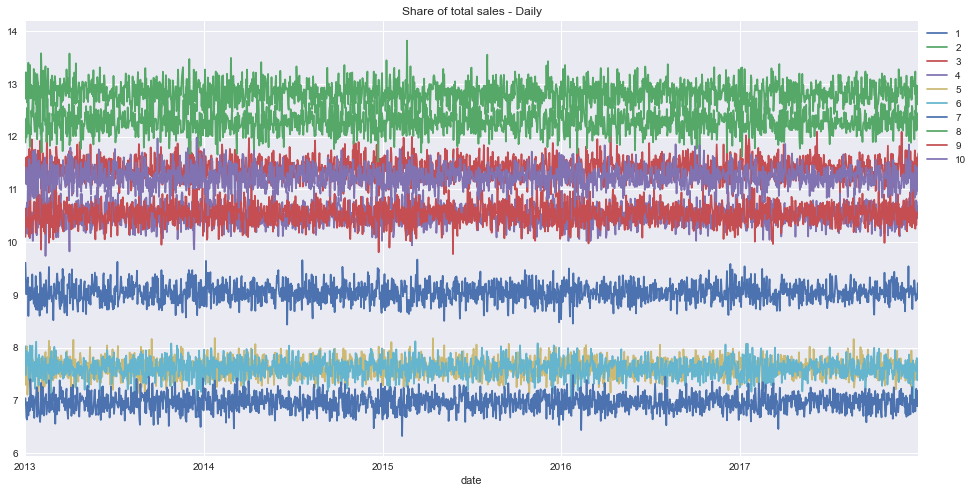

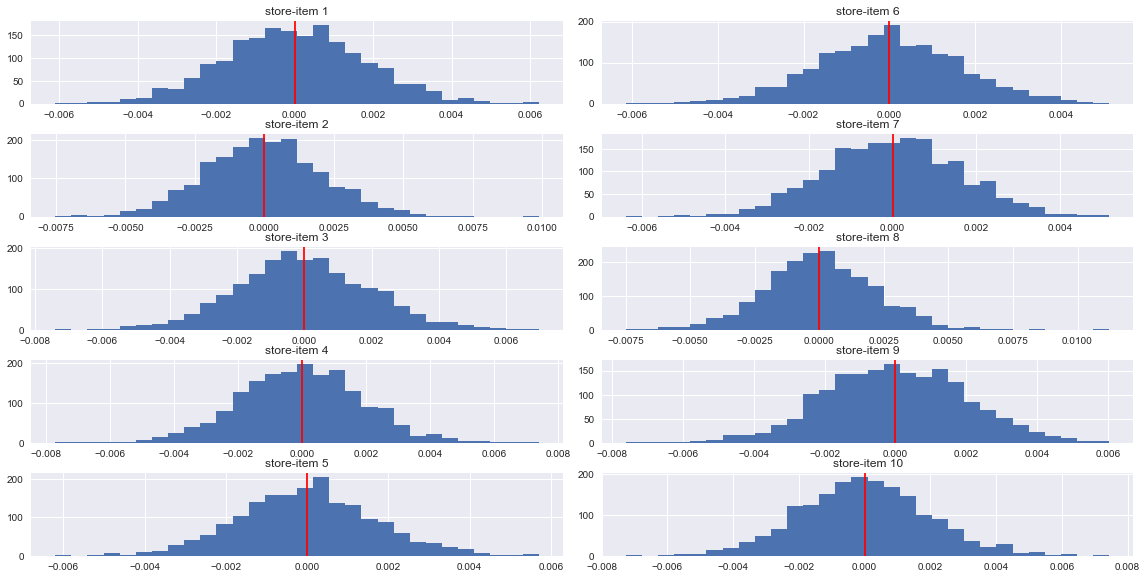

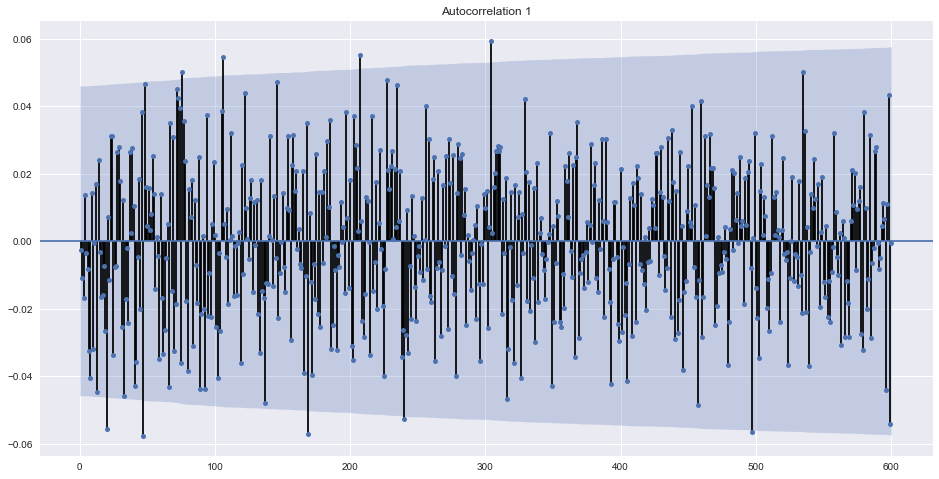

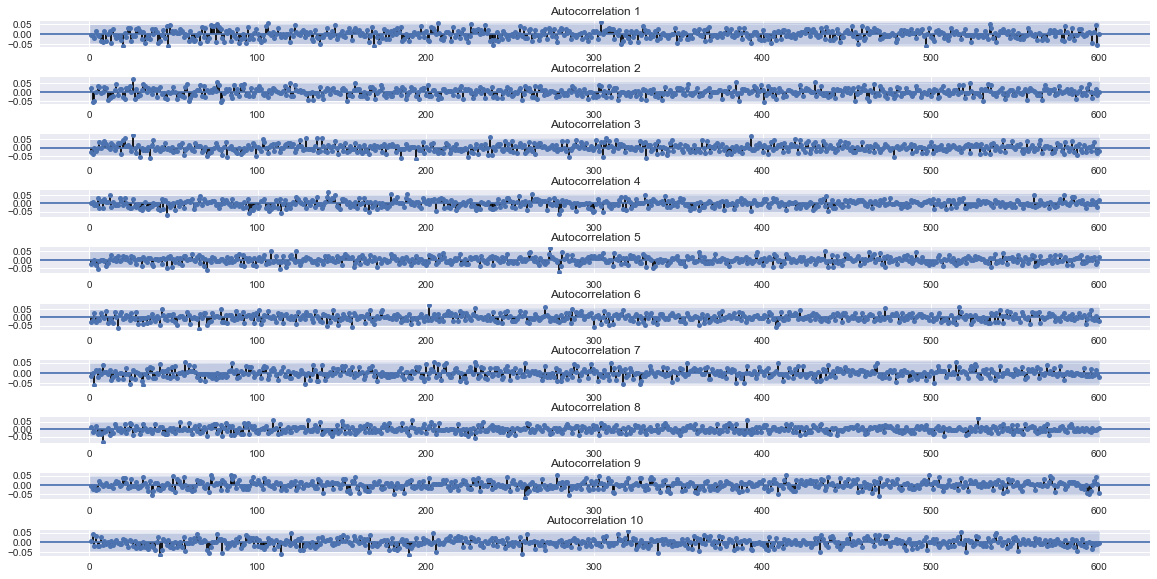

In [7]:
sid.do_share_analysis(df_h, list_cols=hierarchy['total'])

## Repeat analysis at the store-item level

In [8]:
store_items_list = [f'{s}_{i}' for s in range(1,11) for i in range(1,51)]

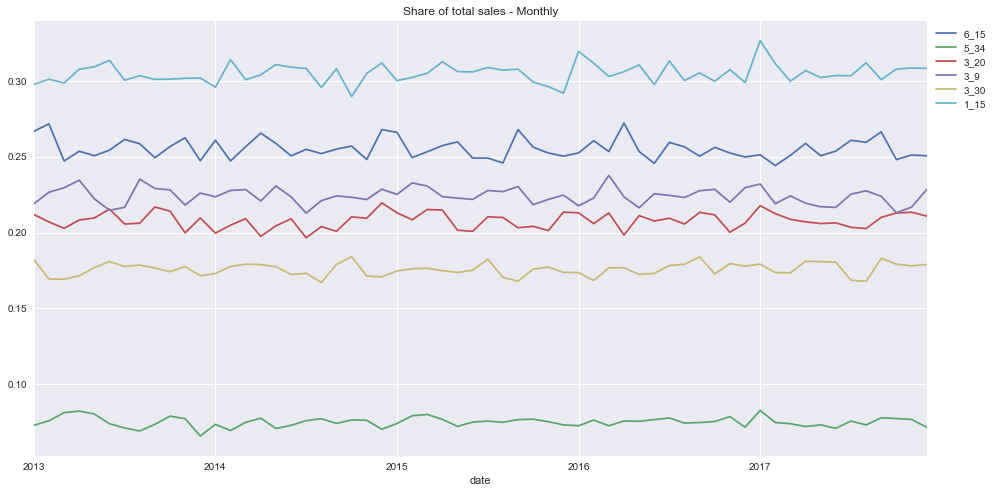

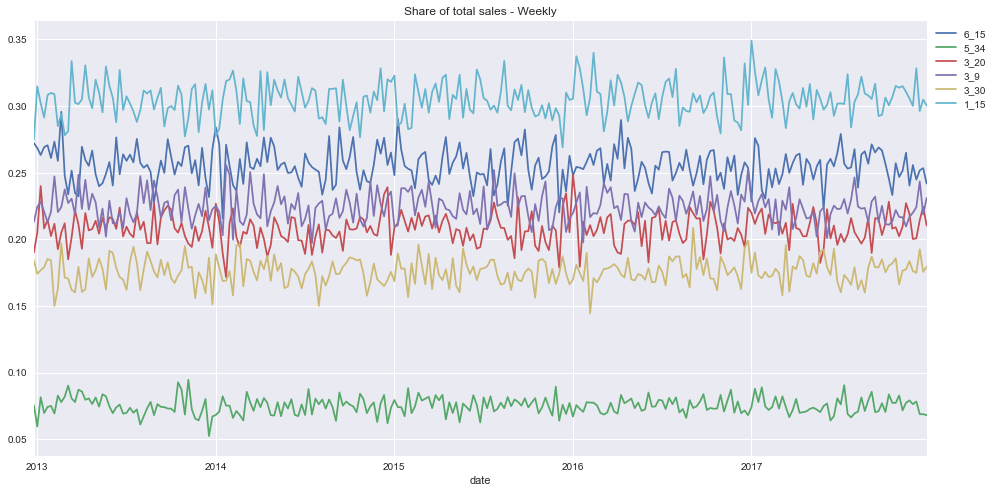

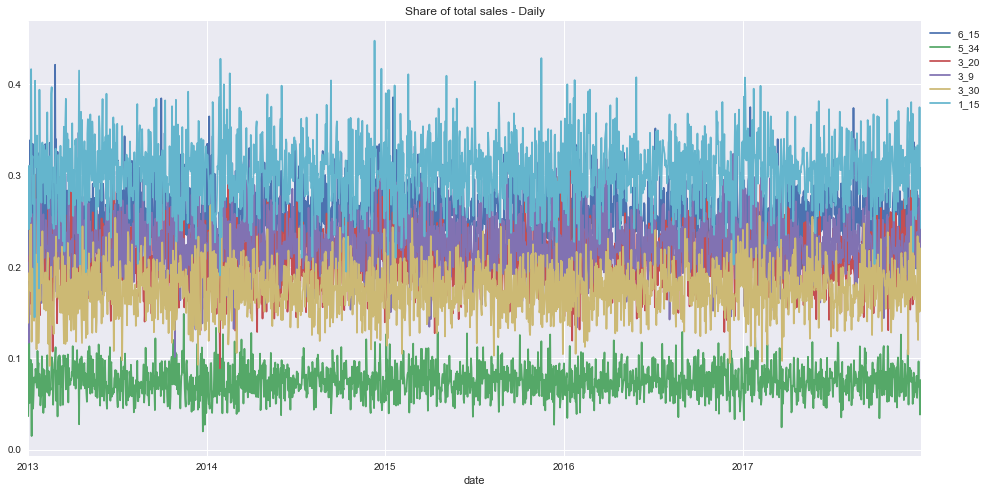

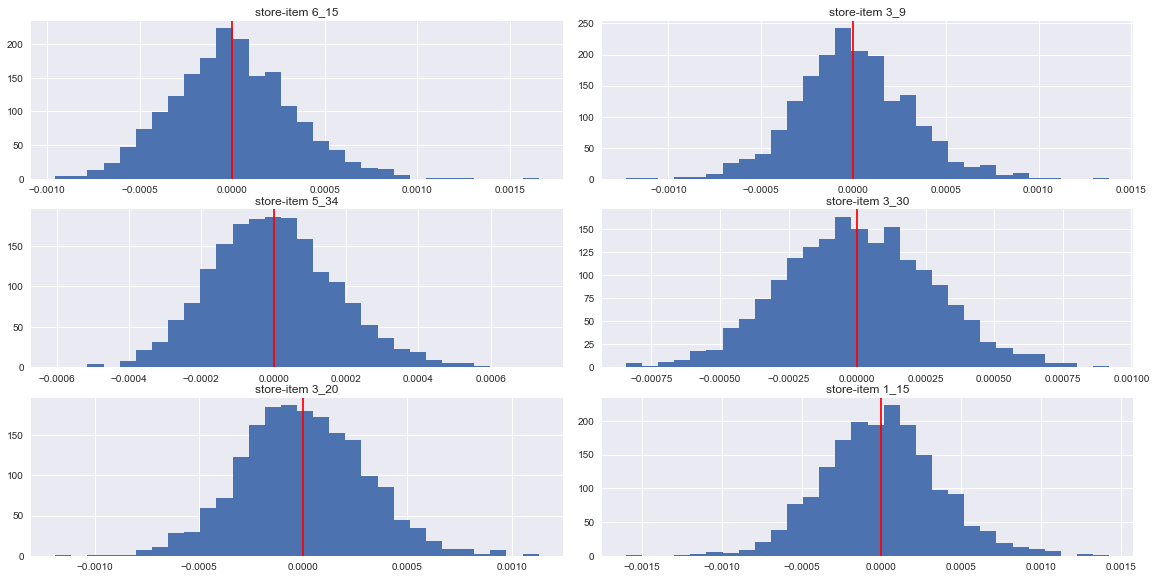

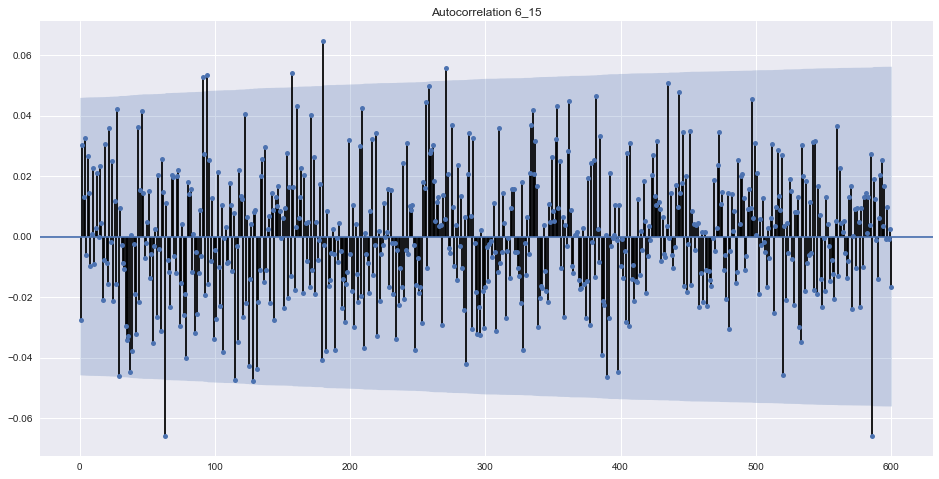

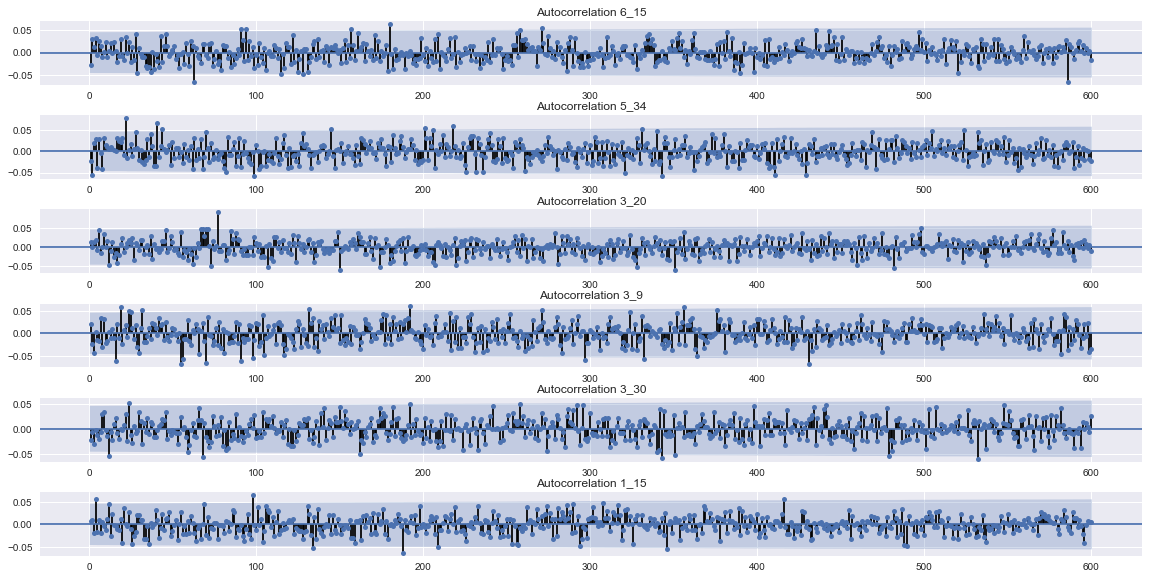

In [9]:
sid.do_share_analysis(df_h, list_cols=store_items_list, n_sample=6)

## Look at total sales distributions

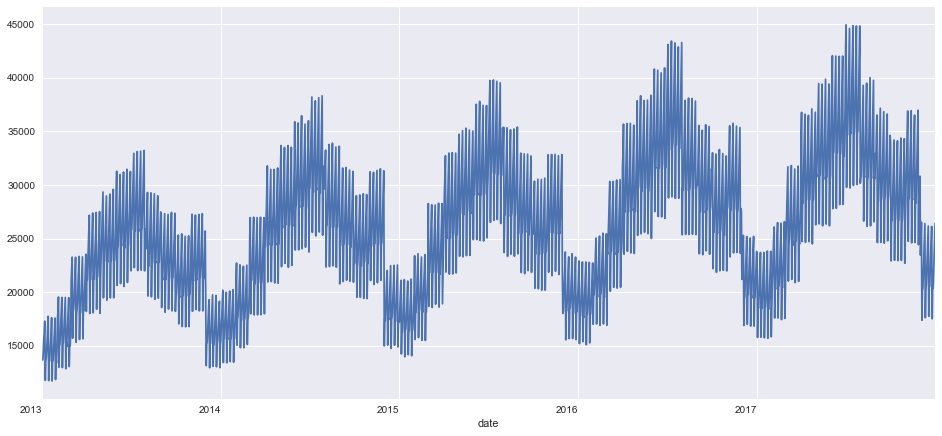

In [10]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax = df_h['total'].plot()

(17167.0, 17561.0)

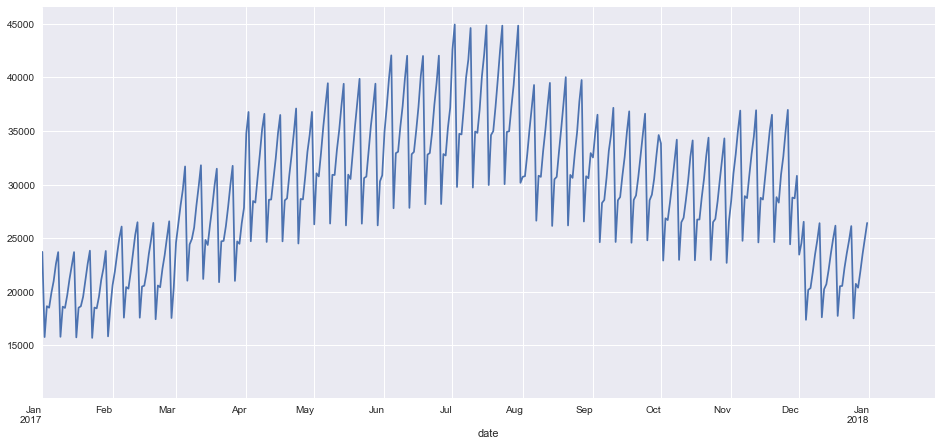

In [11]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax = df_h['total'].plot()
ax.set_xlim([date(2017, 1, 1), date(2018, 1, 30)])

## Modeling and evaluation

In [12]:
splits = sid.shf_split(df_h, n_years_min_training=2.5, horizon=90, 
                       n_max_splits=None)
                       #n_max_splits=10)


# full train start : '2013-01-01'
# full train end   : '2017-12-31'
# min train end    : '2015-07-02'
# horizon          :  90 days
    
# number of cutoffs: 19
2017-10-02
2017-08-18
2017-07-04
2017-05-20
2017-04-05
2017-02-19
2017-01-05
2016-11-21
2016-10-07
2016-08-23
2016-07-09
2016-05-25
2016-04-10
2016-02-25
2016-01-11
2015-11-27
2015-10-13
2015-08-29
2015-07-15


In [13]:
store_items_list = [f'{s}_{i}' for s in range(1,11) for i in range(1,51)]

average SMAPE: 0.292


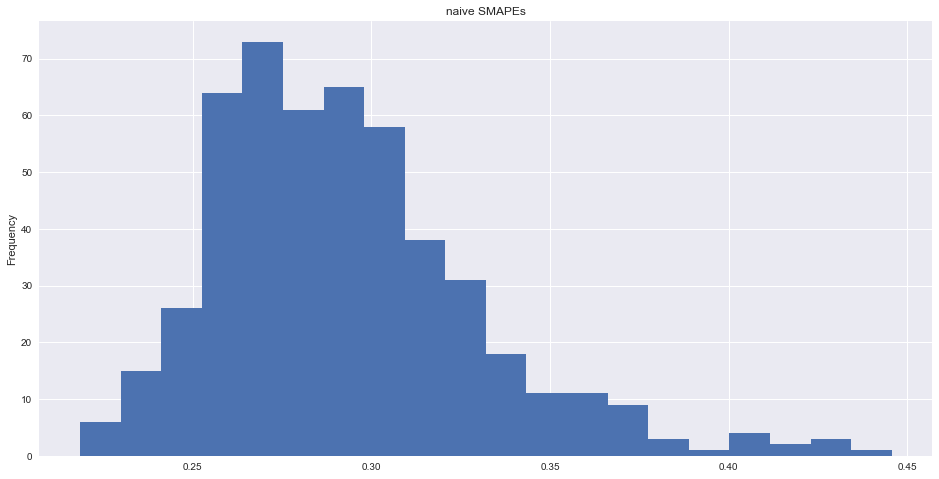

In [14]:
# Naive method
df_results_naive, df_perf_naive = sid.do_all_shf_steps(splits, store_items_list, 
                                                       algo='naive', H=90, verbose=False)

average SMAPE: 0.240


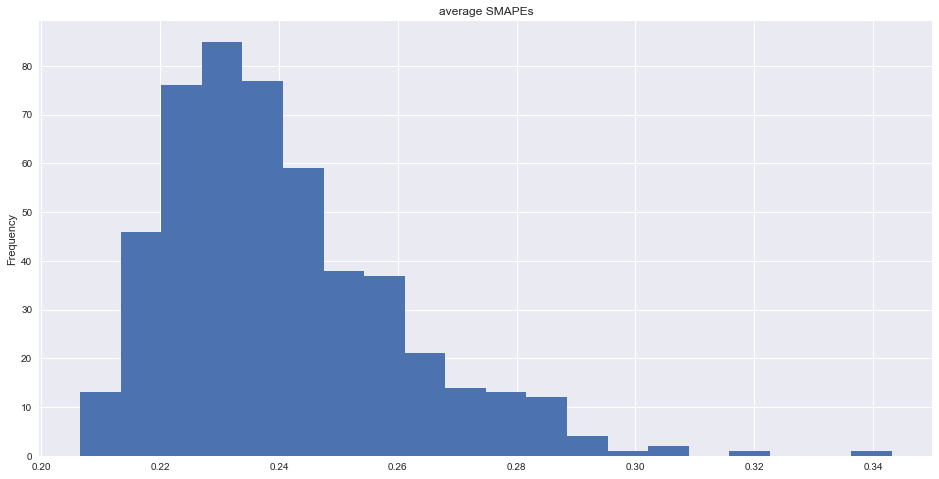

In [15]:
df_results_avg, df_perf_avg = sid.do_all_shf_steps(splits, store_items_list, 
                                                   algo='average', H=90, verbose=False)

average SMAPE: 0.255


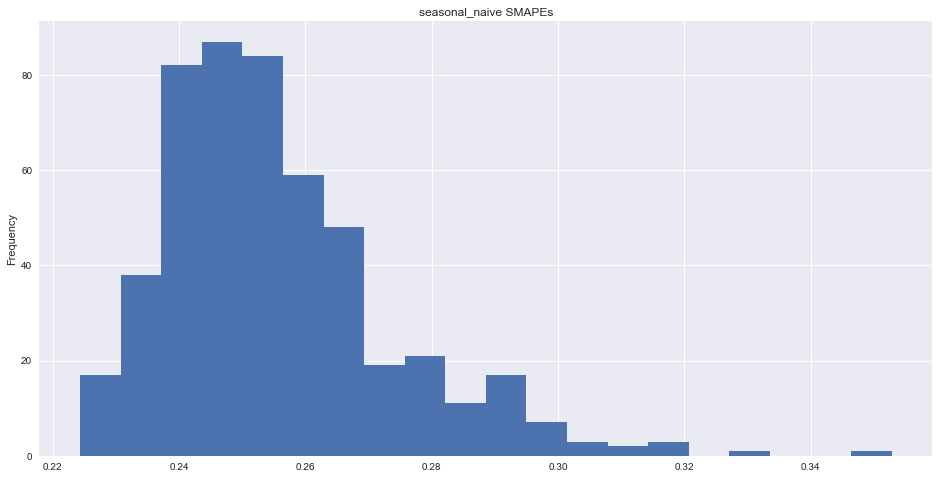

In [16]:
df_results_snaive, df_perf_snaive = sid.do_all_shf_steps(splits, store_items_list, 
                                                         algo='seasonal_naive', H=90, verbose=False)

In [18]:
smape_average  = df_perf_avg.groupby('h_days')['smape'].mean()
smape_naive    = df_perf_naive.groupby('h_days')['smape'].mean()
smape_snaive   = df_perf_snaive.groupby('h_days')['smape'].mean()

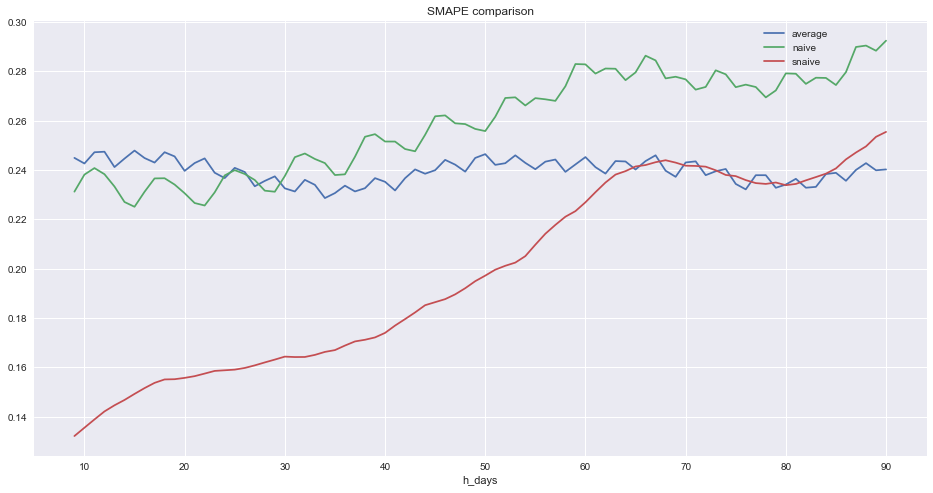

In [19]:
df_smape = pd.concat([smape_average, smape_naive, smape_snaive], axis=1)
df_smape.columns = ['average', 'naive', 'snaive']

ax = df_smape.plot(title='SMAPE comparison')
ax.legend(bbox_to_anchor=(0.9, 1.0));

### Here we start with not-simple methods

In [20]:
df_train = df_h['total'].reset_index()
df_train.columns = ['ds','y']

# on/off season will be used later for more complex models
df_train['off_season'] = ~df_train['ds'].apply(sid.is_on_season)  #winter: Dec, Jan, Feb
df_train['on_season']  = df_train['ds'].apply(sid.is_on_season)    # on season: rest of year

residuals mean=0.11
Top 10 residuals


ds
2013-12-01    4963.279527
2017-12-02    4516.787208
2017-07-30    4451.884768
2017-11-30    4329.065242
2017-12-01    4287.951778
2016-11-30    4276.597760
2016-07-31    4177.722891
2014-11-30    4125.990968
2016-11-29    4102.862008
2017-12-03    3833.635656
Name: res, dtype: float64

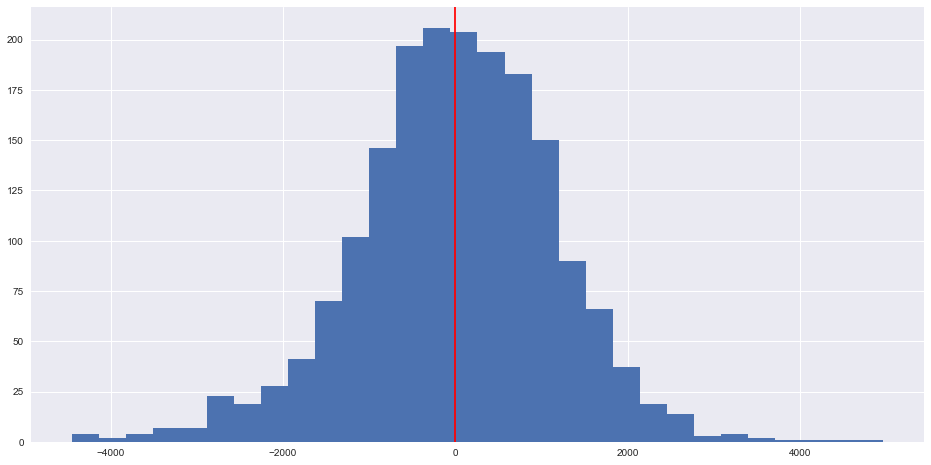

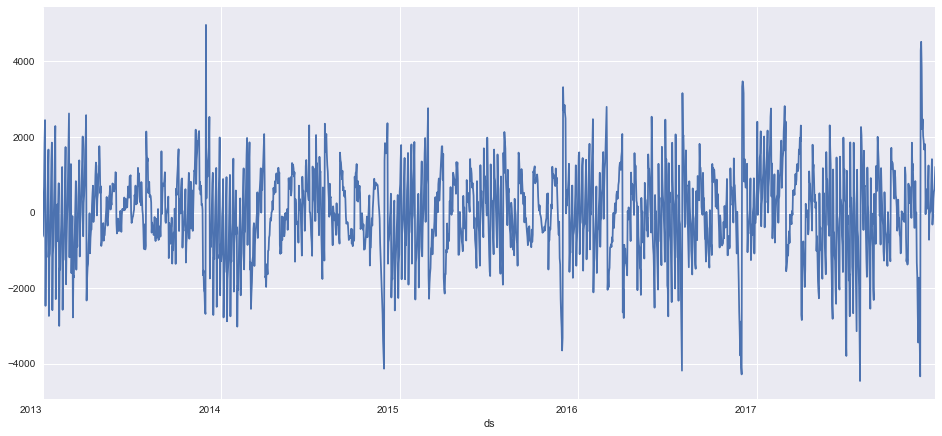

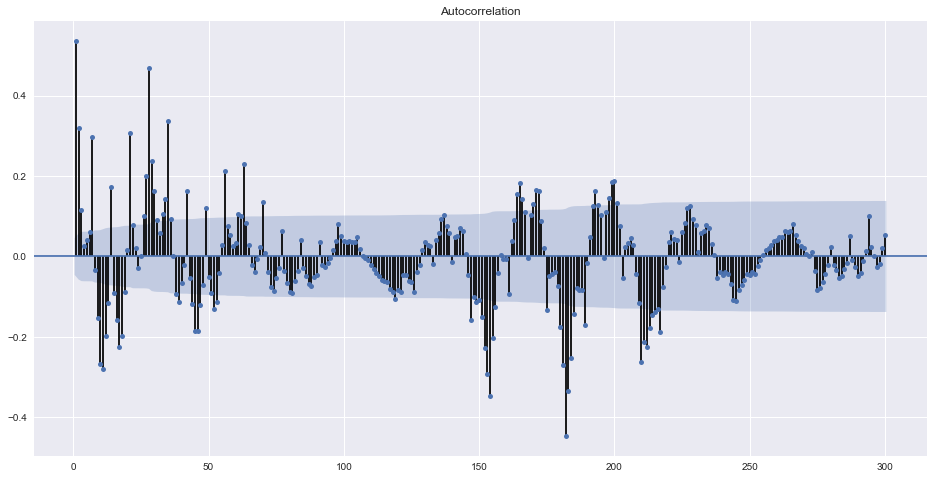

In [21]:
m1, df_forecast1, ts_res1 = sid.model_first_check('model1', df_train, H=90)

In [ ]:
df_results_model1, df_perf_model1 = sid.do_all_shf_steps(splits, store_items_list, 
                                                         algo='model1', H=90, verbose=False)

In [ ]:
smape_model1   = df_perf_model1.groupby('h_days')['smape'].mean()
df_smape = pd.concat([smape_average, smape_naive, smape_snaive,
                      smape_model1], axis=1)
df_smape.columns = ['average', 'naive', 'snaive', 'model1']

ax = df_smape.plot(title='SMAPE comparison')
ax.legend(bbox_to_anchor=(0.9, 1.0));

In [ ]:
m2, df_forecast2, ts_res2 = sid.model_first_check('model2', df_train, H=90)

In [ ]:
df_results_model2, df_perf_model2 = sid.do_all_shf_steps(splits, store_items_list, 
                                                         algo='model2', H=90, verbose=False)

In [ ]:
# plotting
smape_model2   = df_perf_model2.groupby('h_days')['smape'].mean()

df_smape = pd.concat([smape_model1, smape_model2], axis=1)
df_smape.columns = ['model1', 'model2']

ax = df_smape.plot(title='SMAPE comparison')
ax.legend(bbox_to_anchor=(0.9, 1.0));

In [ ]:
m3, df_forecast3, ts_res3 = sid.model_first_check('model3', df_train, H=90)

In [ ]:
df_results_model3, df_perf_model3 = sid.do_all_shf_steps(splits, store_items_list, 
                                                         algo='model3', H=90, verbose=False)

In [ ]:
# plotting
smape_model3   = df_perf_model3.groupby('h_days')['smape'].mean()

df_smape = pd.concat([smape_model1, smape_model2, smape_model3], axis=1)
df_smape.columns = ['model1', 'model2', 'model3']

ax = df_smape.plot(title='SMAPE comparison')
ax.legend(bbox_to_anchor=(0.9, 1.0));

In [ ]:
plot_plotly(m3, df_forecast3)

In [ ]:
m4, df_forecast4, ts_res4 = sid.model_first_check('model4', df_train, H=90)

In [ ]:
plot_plotly(m4, df_forecast4)

In [ ]:
fig2 = m4.plot_components(df_forecast4)

In [ ]:
df_results_model4, df_perf_model4 = sid.do_all_shf_steps(splits, store_items_list, 
                                                         algo='model4', H=90, verbose=False)

In [ ]:
# plotting
smape_model4   = df_perf_model4.groupby('h_days')['smape'].mean()

df_smape = pd.concat([smape_model1, smape_model2, smape_model3, smape_model4], axis=1)
df_smape.columns = ['model1', 'model2', 'model3', 'model4']

ax = df_smape.plot(title='SMAPE comparison')
ax.legend(bbox_to_anchor=(0.9, 1.0));

In [ ]:
m5, df_forecast5, ts_res5 = sid.model_first_check('model5', df_train, H=90)

In [ ]:
fig = m5.plot_components(df_forecast5)

In [ ]:
df_results_model5, df_perf_model5 = sid.do_all_shf_steps(splits, store_items_list, 
                                                         algo='model5', H=90, verbose=False)

In [ ]:
# plotting
smape_model5   = df_perf_model5.groupby('h_days')['smape'].mean()

df_smape = pd.concat([smape_model1, smape_model2, smape_model3, 
                      smape_model4, smape_model5], axis=1)
df_smape.columns = ['model1', 'model2', 'model3', 'model4', 'model5']

ax = df_smape.plot(title='SMAPE comparison')
ax.legend(bbox_to_anchor=(0.9, 1.0));

# Cross-validation

In [ ]:
reload(sid);

## Store-level predictions

In [ ]:
stores = hierarchy['total']
store_cvs, store_perfs = sid.cv_loop(df_h, ts_list=stores, progress_bar=False)

In [ ]:
sid.cv_plot(store_perfs, id_label='store', metric='smape')

In [ ]:
store_perfs['1']

## Item-level predictions

In [ ]:
stores = hierarchy['total']
n_sample_stores = 3
n_sample_items = 5

In [ ]:
stores_sample = random.sample(stores, n_sample_stores)
item_perfs_all = {}
for s in stores_sample:
    items = hierarchy[s]
    items_sample = random.sample(items, n_sample_items)
    #print(items_sample)
    item_cvs, item_perfs = sid.cv_loop(df_h, ts_list=items_sample, progress_bar=False)
    sid.cv_plot(item_perfs, id_label='item')
    item_perfs_all.update(item_perfs)

In [ ]:
sum_smape   = 0
count_smape = 0
for k,v in item_perfs_all.items():
    sum_smape   += item_perfs_all[k]['smape'].sum()
    count_smape += item_perfs_all[k]['smape'].count()

In [ ]:
final_overall_smape = sum_smape/count_smape

In [ ]:
final_overall_smape

# Hierarchical time series forecasting

In [ ]:
xmin = '2015-01-01'
xmax = '2015-03-30'
x_range = [xmin, xmax]

In [ ]:
ax = df_h[hierarchy['total']].plot(title="Sales - store level")
ax.legend(bbox_to_anchor=(1.0, 1.0));
ax.set_xlim(x_range);

In [ ]:
ax = df_h[hierarchy['2'][16:17]].plot(title="Sales - item level")
ax.legend(bbox_to_anchor=(1.0, 1.0));
xmin = '2016-01-01'
xmax = '2016-02-01'
x_range = [xmin, xmax]
ax.set_xlim(x_range);

In [ ]:
ax = df_h[hierarchy['2'][40:50]].plot(title="Sales - item level")
ax.legend(bbox_to_anchor=(1.0, 1.0));
ax.set_xlim(x_range);

In [ ]:
#tree = HierarchyTree.from_nodes(hierarchy, df_h, root='total')

In [ ]:
reload(sid);

In [ ]:
pred_hts = sid.calc_store_hier_preds(hierarchy, df_h, store_idx='1')

In [ ]:
sid.plot_comparison(df_train=df_h, df_preds=pred_hts,
                    idx='1', xmin = '2017-09-20', xmax = None)

In [ ]:
sid.plot_comparison(df_train=df_h, df_preds=pred_hts,
                    idx='1_35', xmin = '2016-09-20', xmax = '2017-09-20')

# Model evaluation

In [ ]:
reload(sid);

In [ ]:
#df_h, hierarchy

In [ ]:
# Preparing the datasets for the simulated historical forecasts
shf_splits = sid.shf_split(df_h, n_years_min_training=3.5, horizon=90)

### Bottom-up with naive method

In [ ]:
# Getting forecasts for all SHF datasets
forecasts_dict = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='naive',
                                        n_store=None, n_store_items=None, 
                                        verbose=False)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./bu_naive.pickle', obj=forecasts_dict)

In [ ]:
df_perf = sid.eval_performance(forecasts_dict)

In [ ]:
mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.2f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Naive bottom-up SMAPEs')

### Bottom-up with Average method

In [ ]:
# Getting forecasts for all SHF datasets
forecasts_dict = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='average',
                                        n_store=None, n_store_items=None, 
                                        verbose=False)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./bu_average.pickle', obj=forecasts_dict)

In [ ]:
df_perf = sid.eval_performance(forecasts_dict)

In [ ]:
mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.2f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Average bottom-up SMAPEs')

### Bottom-up with Prophet

In [ ]:
# Getting forecasts for all SHF datasets
forecasts_dict_prophet = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='prophet',
                                                n_store=None, n_store_items=None, 
                                                verbose=True)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./test.pickle', obj=forecasts_dict_prophet)

In [ ]:
# Reading results previously persisted
forecasts_dict_prophet = sid.read_pickle(filename='./prophet_results.pickle')

In [ ]:
# Evaluating a bunch of performance metrics
df_perf_prophet = sid.eval_performance(forecasts_dict_prophet)

In [ ]:
mean_smape = df_perf_prophet.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.3f}')
ax = df_perf_prophet.query(f'h_days==90')['smape'].plot(kind='hist', 
                                                        bins=20, 
                                                        title='Prophet bottom-up SMAPEs')

### As above, but with multiplicative seasonality

In [ ]:
# Getting forecasts for all SHF datasets
forecasts_dict_prophet = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='prophet',
                                                n_store=None, n_store_items=None,
                                                seasonality_mode='multiplicative', H=90,
                                                verbose=True)

In [ ]:
# Persist results so that we don't have to re-run this every-time
#sid.write_pickle(filename='./prophet_multiplicative.pickle', obj=forecasts_dict_prophet)

In [ ]:
# Reading results previously persisted
forecasts_dict_hts = sid.read_pickle(filename='./prophet_multiplicative.pickle')

In [ ]:
df_perf = sid.eval_performance(forecasts_dict_prophet)

mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.3f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Prophet (multiplicative) bottom-up SMAPEs')

### Hierarchical Optimal fit (2-levels) with Prophet

In [ ]:
reload(sid);

In [ ]:
forecasts_dict = sid.shf_forecasts_loop_for_hier_method(hierarchy, shf_splits, 
                                                        n_store=None,
                                                        verbose=True, H=90)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./hts1.pickle', obj=forecasts_dict)

In [ ]:
# Reading results previously persisted
forecasts_dict_hts = sid.read_pickle(filename='./hts1.pickle')

df_perf = sid.eval_performance(forecasts_dict_hts)

mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.3f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Hierarchical top-down SMAPEs')

## Detailed analysis of best model 

In [ ]:
forecasts_dict_shf = sid.read_pickle(filename='./prophet_multiplicative.pickle')

In [ ]:
df_perf = sid.eval_performance(forecasts_dict_shf)

In [ ]:
mean_smape = df_perf.query(f'h_days==10')['smape'].mean()
print(f'average SMAPE: {mean_smape:.3f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Hierarchical top-down SMAPEs')

In [ ]:
df_perf.head()